# Capstone: Sentiment Analysis for Shopee
## Data Collection, Data Cleaning, Pre-processing and EDA
__Grace Chia__

---

## Problem Statement

Shopee is a fast-growing e-commerce platform in Southeast Asia. In order to build an enjoyable online shopping experience, Shopee's product managers would first need to identify customer sentiment and understand users' pain points.

As such, the data science team has been tasked to classify the positive and negative reviews on Shopee Singapore's Google Play using Natural Language Processing (NLP). The model that achieves the highest accuracy and recall on the validation set will be selected for production. The team will be using topic modeling to identify the key pain points among dissatisfied customers. This will enable product managers to address their immediate needs.

## Background

<img src="../images/ecommerce_market_size.png" width="400" align="left">

Source: Google, Temasek, Bain & Company e-Conomy SEA 2019

According to research done by [Google, Temasek and Bain](https://www.thinkwithgoogle.com/intl/en-apac/tools-resources/research-studies/e-conomy-sea-2019-swipe-up-and-to-the-right-southeast-asias-100-billion-internet-economy/), Singapore's e-commerce market was worthed US\\$2 billion in 2019, and is expected to grow 3.5 times to reach US\\$7 billion by 2025. High mobile penetration and fast internet connectivity, will be the key drivers of e-commerce growth. Furthermore, as consumers were encouraged to stay home as a result of COVID-19, many have started to grow accustomed to shopping online. This may just be the start of a new norm in consumer behaviour, where more start to shift from offline to online shopping.

While e-commerce presents huge opportunities, competition has been on the rise, with the key players being Lazada, Shopee and Qoo10. In efforts to build customer engagement and grow their share of wallet, competitors have improved the checkout experience, introduced gamification and overcame the challenges of last-mile delivery. Given stiff competition, it is crucial that Shopee continues to delight customers and address pain points in the online shopping experience. The sentiment analysis tool will enable Shopee's product managers to classify user sentiment accurately and understand the pain points.

## Methodology

**Data collection**:  
The scraping was done using [Google-Play-Scraper](https://github.com/JoMingyu/google-play-scraper) to collect users' reviews and ratings on Shopee's app. A total of 4,461 unique reviews were collected.

**Data cleaning**:
- Remove duplicated reviews
- Remove reviews that do not have any meaningful words
- Remove reviews that are non-English or gibberish

**Pre-processing**:
- Remove HTML tags
- Use regular expression to remove special characters and numbers
- Lowercase words
- Use NLTK to remove stopwords
- Remove frequently occurring words that appear in both positive and negative sentiments, like 'app', 'shopee', 'item', 'seller', 'bad'.
- Use NLTK to stem words to their root form

## Key Insights from EDA

**Time frame of the reviews written**  
The number of reviews for Shopee on Google Play has increased across all ratings (1-5 stars), between Jan and April 2020. This may likely be a result of the recent rise in e-commerce purchases. As the COVID-19 outbreak resulted in the forced closure of many brick-and-mortar stores during Singapore's circuit breaker period, many consumers started to turn to online shopping instead.

**Number of thumbs up received**  
Negative reviews with 1 or 2-star ratings receive more thumbs up on average, than positive reviews. This may suggest that several others face the same issues as those who have written these negative reviews.

**Number of meaningful words**  
The average number of meaningful words in a negative review (15 words) is higher than that in a positive review (7 words). There is also a noticeable higher variance in the number of meaningful words among negative reviews than positive reviews, suggesting that dissatisfied customers are more likely to write longer reviews. 

**Barplots: Top uni-grams and bi-grams**  
'Use', 'time' and 'order' are the top 3 most frequently occurring uni-grams in negative reviews. 'Customer service' is the top bi-gram seen among negative reviews. We can thus infer that users are somewhat dissatisfied with Shopee's customer service.   

'Good', 'shop' and 'easi' are the top 3 most frequently seen uni-grams in positive reviews. The bi-grams give us some context to the word 'easi', where it probably refers to an 'easy to use online shopping platform'.  

**VADER sentiment analysis**  
Given a compound score threshold of 0.175, VADER is able to correctly classify 80% of sentiments. As Shopee's product managers would also like to prioritise the identification of negative reviews so that they can fix immediate problems if necessary, achieving a decent recall rate is important. VADER is able to correctly classify 74% of actual negative reviews.

## Contents:
- [Import Libraries](#Import-Libraries)
- [Data Collection](#Data-Collection)
- [Data Cleaning & Pre-processing](#Data-Cleaning-&-Pre-processing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)

## Import Libaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Library to scrape Google Play
from google_play_scraper import Sort, reviews

from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%matplotlib inline

## Data Collection

Users can rate [Shopee's app](https://play.google.com/store/apps/details?id=com.shopee.sg&hl=en_SG) on Google Play with a star rating and review. The ratings are on a 5-point scale, with 1 being the lowest score and 5 being the highest score one could possibly give. Since the goal of our project is to predict if a review has a positive or negative sentiment based on textual data, we will scrape real user reviews on Google Play.

[Google-Play-Scraper](https://github.com/JoMingyu/google-play-scraper) provides an API to crawl through Google Play. We used `pip install google-play-scraper` to install the package and scraped users' reviews and rating scores on Shopee's app.  

The reviews were collected in batches, according to their scores (1-5). This was done in an attempt to achieve a balanced dataset with roughly the same number of reviews for each score. Also, in order to gather reviews that had more text and were written recently, we set up the google play scraper to scrape from both review types, 'Most relevant' and 'Newest'.


In [2]:
## Commenting this out so that we don't re-run the cells and accidentally re-collect the data
## Create an empty list to store the reviews that we are about to collect
# app_reviews = []

In [3]:
# # Function to scrape reviews on google play store
# # app: the url of the app we want to scrape
# # score: number of stars rated by users
# # n_loops: the number of loops to collect reviews in batches of 200

# def reviews_scraper(app, score, n_loops):
#     for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]: # Collect both reviews types - 'most relevant' and 'newest'
#         for i in range(n_loops):
#             rvs, continuation_token = reviews(app,
#                                               lang='en',
#                                               country='sg',
#                                               sort=sort_order,
#                                               count=200, # 200 is the maximum number of reviews per page supported by Google Play
#                                               filter_score_with=score,
#                                               continuation_token=None if i==0 else continuation_token) # To begin crawling from where it last left off
#             for r in rvs:
#                 r['sort_order'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
#                 r['app_id'] = app
#             app_reviews.extend(rvs)
#             print('No. of reviews collected: ' + str(len(rvs)))

After setting up our scraping function, we will now collect the reviews in batches, based on their scores. As not many users left 2-3 star reviews on Shopee, hitting the site with more than 2 loops will return an error. Hence, `n_loops` for scores 2 and 3 star reviews were set to 2, rather than 5.

In [4]:
## Collect reviews that were rated 1 star
# reviews_scraper(app='com.shopee.sg', score=1, n_loops=5)

In [5]:
## Collect reviews that were rated 2 stars
# reviews_scraper(app='com.shopee.sg', score=2, n_loops=2)

In [6]:
## Collect reviews that were rated 3 stars
# reviews_scraper(app='com.shopee.sg', score=3, n_loops=2)

In [7]:
## Collect reviews that were rated 4 stars
# reviews_scraper(app='com.shopee.sg', score=4, n_loops=5)

In [8]:
## Collect reviews that were rated 5 stars
# reviews_scraper(app='com.shopee.sg', score=5, n_loops=5)

In [9]:
# # Save reviews to csv file
# pd.DataFrame(app_reviews).to_csv('../data/shopee_reviews.csv', index=False)

In [10]:
# Read in shopee csv file 
# Datetime parsing for 'at' and 'repliedAt' columns
reviews = pd.read_csv('../data/shopee_reviews.csv', parse_dates=['at','repliedAt'])

In [11]:
# We have collected 7404 reviews 
reviews.shape

(7404, 12)

In [12]:
# View first 5 rows
reviews.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sort_order,app_id
0,gp:AOqpTOFnDa9AFOLUIPP1ZHt8YKFFUG8Z6vbRJbsD97Z...,Kat Tay,https://lh3.googleusercontent.com/-osMYVkuXRz0...,2nd review now after 1st mysteriously disappea...,1,6,2.55.08,2020-05-17 14:20:08,NaN,NaT,most_relevant,com.shopee.sg
1,gp:AOqpTOGq4xwzc4ChdGabTitwiThWioMWEbGJ34XE170...,Claire Li Yue,https://lh3.googleusercontent.com/a-/AOh14GgID...,"I wouldn't use this app again, at least for a ...",1,34,2.54.16,2020-04-30 18:39:46,Thank you for your review. We are sorry to hea...,2020-04-30 20:25:06,most_relevant,com.shopee.sg
2,gp:AOqpTOHa3-tT2vSD7rMc3U4EisKB946isfPDk6ThtjI...,Soh Jianke,https://lh3.googleusercontent.com/a-/AOh14GiSW...,The app gets very slow and unresponsive after ...,1,19,2.54.30,2020-05-06 00:48:13,Thank you for bringing this issue to our atten...,2020-05-06 09:17:37,most_relevant,com.shopee.sg
3,gp:AOqpTOF8gxrJbxLW5Px-7Z_8aIR-3wgCdkzyzd65107...,Shridharan Krishnan,https://lh3.googleusercontent.com/a-/AOh14GifN...,Disappointed over and over again. I have been ...,1,15,2.54.30,2020-05-11 21:26:31,NaN,NaT,most_relevant,com.shopee.sg
4,gp:AOqpTOGiye-dORchuzFd9VIxoAV2WmqMHVuHPqZnCrR...,Suling Li,https://lh3.googleusercontent.com/-fT3quvpzvWk...,I purchased 2 fans but i received one product ...,1,11,2.54.29,2020-05-07 22:42:13,Thank you for bringing this issue to our atten...,2020-05-08 09:47:52,most_relevant,com.shopee.sg


In [13]:
# Check that the datatypes are correct eg. 'at' and 'repliedAt' are datetime
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7404 entries, 0 to 7403
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              7404 non-null   object        
 1   userName              7404 non-null   object        
 2   userImage             7404 non-null   object        
 3   content               7404 non-null   object        
 4   score                 7404 non-null   int64         
 5   thumbsUpCount         7404 non-null   int64         
 6   reviewCreatedVersion  6562 non-null   object        
 7   at                    7404 non-null   datetime64[ns]
 8   replyContent          5830 non-null   object        
 9   repliedAt             5830 non-null   datetime64[ns]
 10  sort_order            7404 non-null   object        
 11  app_id                7404 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(8)
memory usage: 694.2+ KB


In [14]:
# Some null values in app version & developer replies
reviews.isnull().sum()

reviewId                   0
userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion     842
at                         0
replyContent            1574
repliedAt               1574
sort_order                 0
app_id                     0
dtype: int64

In [15]:
# Summary statistics for numerical variables
reviews.describe()

,score,thumbsUpCount
count,7404.000000,7404.000000
mean,3.187736,1.602782
std,1.574356,8.407194
min,1.000000,0.000000
25%,1.000000,0.000000
50%,4.000000,0.000000
75%,5.000000,0.000000
max,5.000000,199.000000


In [16]:
# Check how many reviews were retrieved from each score
reviews['score'].value_counts().sort_index()

1    2000
2     610
3     794
4    2000
5    2000
Name: score, dtype: int64

## Data Dictionary

The data dictionary below provides an overview of the features in our dataset.

| Feature              | Type     | Description                                                                                        |
|:----------------------|:----------|:----------------------------------------------------------------------------------------------------|
| reviewId             | obj      | Unique review Id                                                                                   |
| userName             | obj      | Username of the reviewer                                                                           |
| userImage            | obj      | Url link to the user's profile photo                                                                         |
| content              | obj      | Textual data of the review                                                                         |
| score                | int      | No. of star ratings the user gave (1-5)                                                                  |
| thumbsUpCount        | int      | No. of thumbs up the review received from other users                                              |
| reviewCreatedVersion | obj      | App version                                                                                        |
| at                   | datetime | Date and time of which the review was written                                                      |
| replyContent         | obj      | Shopee's reply to the review                                                                       |
| repliedAt            | datetime | Date and time of Shopee's reply                                                                    |
| sort_order           | obj      | Indicates whether the data was scraped from the 'Most relevant' or 'Newest' section in Google Play |
| app_id               | obj      | The url which the reviews were collected from                                                      |

## Data Cleaning & Pre-processing

### Remove duplicated reviews

As we have scraped reviews that were sorted by 'Most relevant' and 'Newest', there will definitely be duplicates in our dataset. We will be dropping these duplicates to ensure that we train and test our model on unique reviews.

In [17]:
# 7404 reviews in our dataframe
reviews.shape

(7404, 12)

In [18]:
# There are 2943 duplicates
reviews[reviews.duplicated(['userName', 'content', 'at'])].shape

(2943, 12)

In [19]:
# Drop duplicates as we only want unique reviews
reviews.drop_duplicates(['userName', 'content', 'at'], inplace=True)

In [20]:
# Reindex the dataframe
reviews.reset_index(drop=True, inplace=True)

In [21]:
# Check that we have dropped these duplicates
reviews.shape

(4461, 12)

In [22]:
# Check how many reviews we have for each score after dropping the duplicates
reviews['score'].value_counts().sort_index()

1    1053
2     305
3     397
4    1011
5    1695
Name: score, dtype: int64

### Rename columns

It is good practice to use snake case when naming our columns.

In [23]:
# Rename the columns to lowercase and use underscores
reviews.rename(columns={'reviewId': 'review_id', 
                        'userName': 'username', 
                        'userImage': 'user_image', 
                        'thumbsUpCount': 'thumbs_up_count', 
                        'reviewCreatedVersion': 'review_created_version', 
                        'replyContent': 'reply_content',
                        'repliedAt': 'replied_at'},
              inplace=True)

In [24]:
# Check that columns have been correctly renamed
reviews.columns

Index(['review_id', 'username', 'user_image', 'content', 'score',
       'thumbs_up_count', 'review_created_version', 'at', 'reply_content',
       'replied_at', 'sort_order', 'app_id'],
      dtype='object')

### Create a target variable

The goal is to classify positive and negative app reviews. Negative reviews can reveal critical features that are missing from Shopee's app or even bring to light the presence of bugs on the app. This will require immediate action from Shopee. As such, priority will be placed on the prediction of negative sentiment. We will assign the negative reviews (scores 1-3) to class 1, and the positive reviews (scores 4-5) to class 0.

In [25]:
# Defining the target variable using scores
reviews['target'] = reviews['score'].map(lambda x: 1 if x < 4 else 0)

In [26]:
# Check the count of our target variable
reviews['target'].value_counts()

0    2706
1    1755
Name: target, dtype: int64

In [27]:
# Check that the target variable has been added to our dataframe
reviews.head()

,review_id,username,user_image,content,score,thumbs_up_count,review_created_version,at,reply_content,replied_at,sort_order,app_id,target
0,gp:AOqpTOFnDa9AFOLUIPP1ZHt8YKFFUG8Z6vbRJbsD97Z...,Kat Tay,https://lh3.googleusercontent.com/-osMYVkuXRz0...,2nd review now after 1st mysteriously disappea...,1,6,2.55.08,2020-05-17 14:20:08,NaN,NaT,most_relevant,com.shopee.sg,1
1,gp:AOqpTOGq4xwzc4ChdGabTitwiThWioMWEbGJ34XE170...,Claire Li Yue,https://lh3.googleusercontent.com/a-/AOh14GgID...,"I wouldn't use this app again, at least for a ...",1,34,2.54.16,2020-04-30 18:39:46,Thank you for your review. We are sorry to hea...,2020-04-30 20:25:06,most_relevant,com.shopee.sg,1
2,gp:AOqpTOHa3-tT2vSD7rMc3U4EisKB946isfPDk6ThtjI...,Soh Jianke,https://lh3.googleusercontent.com/a-/AOh14GiSW...,The app gets very slow and unresponsive after ...,1,19,2.54.30,2020-05-06 00:48:13,Thank you for bringing this issue to our atten...,2020-05-06 09:17:37,most_relevant,com.shopee.sg,1
3,gp:AOqpTOF8gxrJbxLW5Px-7Z_8aIR-3wgCdkzyzd65107...,Shridharan Krishnan,https://lh3.googleusercontent.com/a-/AOh14GifN...,Disappointed over and over again. I have been ...,1,15,2.54.30,2020-05-11 21:26:31,NaN,NaT,most_relevant,com.shopee.sg,1
4,gp:AOqpTOGiye-dORchuzFd9VIxoAV2WmqMHVuHPqZnCrR...,Suling Li,https://lh3.googleusercontent.com/-fT3quvpzvWk...,I purchased 2 fans but i received one product ...,1,11,2.54.29,2020-05-07 22:42:13,Thank you for bringing this issue to our atten...,2020-05-08 09:47:52,most_relevant,com.shopee.sg,1


### Pre-processing

Next, we will perform pre-processing to transform our text into a more digestible form for our classifier. The steps are as follows:
- Remove HTML tags
- Use regular expression to remove special characters and numbers
- Lowercase words
- Use NLTK to remove stopwords
- Remove frequently occurring words that appear in both positive and negative sentiments, like 'app', 'shopee', 'item', 'seller', 'bad'. Removing these words led to a 1 and 2 percentage point improvement in our model's accuracy and recall rate, respectively.
- Use NLTK to stem words to their root form. Note that the model returned better accuracy when we used stemming, rather than lemmatizing.

It is also good to note that we have tried using SpaCy to remove stopwords and for lemmatizing. However, our model's performance was much better when the text was pre-processed using NLTK.

In [28]:
# Write a function to convert raw text to a string of meaningful words
def stem_text(raw_text):
  
    # Remove HTML tags
    review_text = BeautifulSoup(raw_text).get_text()
    
    # Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # Convert words to lower case and split each word up
    words = letters_only.lower().split()
    
    # Searching through a set is faster than searching through a list 
    # Hence, we will convert stopwords to a set
    stops = set(stopwords.words('english'))
    
    # Adding on stopwords that were appearing frequently in both positive and negative reviews 
    stops.update(['app','shopee','shoppee','item','items','seller','sellers','bad']) 
    
    # Remove stopwords
    meaningful_words = [w for w in words if w not in stops]
        
    # Instantiate PorterStemmer
    p_stemmer = PorterStemmer()
    
    # Stem words
    meaningful_words = [p_stemmer.stem(w) for w in meaningful_words]        
   
    # Join words back into one string, with a space in between each word
    return(" ".join(meaningful_words))

In [29]:
# Pre-process the raw text
reviews['content_stem'] = reviews['content'].map(stem_text)

Let us compare our original text with the pre-processed version.

In [30]:
# This is the original text of the first review in our dataset
reviews.loc[0]['content']

'2nd review now after 1st mysteriously disappeared. My feedback remains the same, this is a joke of a shopping platform where you can\'t redeem the gift for new user due to "network error" but no such issue with buying other items. Coupons for new user ends up in the invalid section on the same day when you sign up. Seriously if you can\'t afford the marketing budget to attract new user that\'s fine. Just don\'t over promise and under deliver... and stop deleting negative feedback.'

In [31]:
# This is how the text looks like after stemming
reviews.loc[0]['content_stem']

'nd review st mysteri disappear feedback remain joke shop platform redeem gift new user due network error issu buy coupon new user end invalid section day sign serious afford market budget attract new user fine promis deliv stop delet neg feedback'

### Remove reviews that do not have any meaningful words

After pre-processing, we notice that there are some reviews that do not have any meaningful words left. As these reviews largely consists of only emojis or Chinese characters, these reviews returned blank fields after stemming. In other words, the length of these reviews after pre-processing, was 0. Given that these reviews will not add value to our model's training, we will remove them from our dataset. 

In [32]:
# Find the number of meaningful words in each review
reviews['content_clean_len'] = reviews['content_stem'].str.split().map(len)

In [33]:
# There are 48 reviews that do not have any meaningful words
reviews[reviews['content_clean_len']==0].shape

(48, 15)

In [34]:
# View reviews that do not have any meaningful words
reviews[reviews['content_clean_len']==0]['content']

823                                  😇😇😇😇😇😇👍👍👍👍👍👍👍👍👍👍✌✌✌✌
938                                                   Bad
1006                                                    😓
1010                                                    👎
1029                                                  Bad
1603                                                  还行吧
1610                                                   👍🏻
1611                                               So..so
1613                                                   👍👍
2578                                                   👍🏻
2606                                              Not bad
2609                                             Not bad.
2614                                            Not bad !
2617                                                  😀😀😀
2623                                                   👍😄
2650                                                  👍👍👍
2669    我觉得在这个地方购物买东西是很好的，为我欣赏的是就是他们送货的速度比较快。可能在一个星期里面...
2684          

In [35]:
# Drop these reviews that do not have any meaningful words
reviews = reviews.drop(reviews[reviews['content_clean_len']==0].index)

In [36]:
# Reindex the dataframe
reviews.reset_index(drop=True, inplace=True)

### Remove reviews that are non-English or gibberish

We have identified several reviews that were written in non-English or simply gibberish. As we would like to train and test our model with only English text, we will remove these reviews to reduce the noise in our dataset.

In [37]:
# Index of reviews to drop
reviews_to_drop = [760,791,815,822,833,835,842,843,846,847,849,852,853,
                   854,855,857,887,1000,1003,1011,1012,1018,1019,1020,1021,
                   1022,1032,1036,1039,1211,1218,1221,1334,1336,1342,1343,1347,
                   1348,1351,1600,1601,1604,1609,1611,1637,1664,1708,1730,1737,
                   2520,2566,2589,2626,2627,2733,3831,3864,3866,3901,3986,4044,
                   4203,4262,4279,4365]

In [38]:
# There are 65 non-English or gibberish reviews
len(reviews_to_drop)

65

In [39]:
# View all the reviews that are non-English or gibberish
reviews.loc[reviews_to_drop,'content']

760     dmakapag sign in at wala daw account may balan...
791              Knpa Tak bole download shopee Malaysia??
815     bakit dollar ang curency ng presyo.ng items da...
822                    Dollar ba talaga mga presyo dito??
833                                                  Jssj
                              ...                        
4044                                                   Gd
4203                                           No comment
4262                                                  Nil
4279                                                 Peso
4365                                              Not baf
Name: content, Length: 65, dtype: object

In [40]:
# Check shape of dataframe before dropping
reviews.shape

(4413, 15)

In [41]:
# Drop these reviews
reviews.drop(reviews_to_drop, inplace=True)

In [42]:
# Check that these reviews have been dropeed
reviews.shape

(4348, 15)

### Create a train and test set

20% of the original dataset will be set aside and used as a test set. This will be useful in evaluating our model's performance on unseen data.  

We will use stratify to preserve the class representation in our train and test set.

In [43]:
# As we would like to stratify our target variable, we will need to first assign X and y
X = reviews[[cols for cols in reviews.columns if cols != 'target']]
y = reviews['target']

In [44]:
# Perform a train_test_split to create a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [45]:
# Merge X_train and y_train back together using index
train = pd.merge(X_train, y_train, left_index=True, right_index=True)

# Merge X_test and y_test back together using index
test = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [46]:
# Reindex the train and test set
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [47]:
# 3478 documents in our training set
train.shape

(3478, 15)

In [48]:
# 870 documents in our test set
test.shape

(870, 15)

In [49]:
# Check split in class labels for training set
train['target'].value_counts(normalize=True)

0    0.609833
1    0.390167
Name: target, dtype: float64

In [50]:
# Check split in class labels for test set
test['target'].value_counts(normalize=True)

0    0.609195
1    0.390805
Name: target, dtype: float64

Finally, after data cleaning, we now have 3478 reviews for training and 870 reviews in our test set. The class representation is consistent across the train and test set, with 61% of the data belonging to class 0 (positive sentiment) and 39% belonging to class 1 (negative sentiment).

## Exploratory Data Analysis

We will perform EDA to draw insights from our training set. This step is also crucial in helping us determine if any more pre-processing is necessary before training the model.

### Time frame of the reviews written

We will compare the distributions of the review dates across various ratings, 1-5.

In [51]:
# Create histogram subplots for each rating (1-5)
# Each subplot represents the distribution of the dates at which the reviews were written
def subplot_histograms(main_title, list_of_titles, xlabels, list_of_colors):
    fig, ax = plt.subplots(5, 1, figsize=(8,10), sharex=True, sharey=True)
    for i in range(5):
        ax[i].hist(train[train['score']==(i+1)]['at'], bins=50, color=list_of_colors[i])
        ax[i].set_title(list_of_titles[i], weight='bold')
        ax[i].set_xlabel(xlabels)
        ax[i].set_ylabel('Frequency')
    fig.suptitle(main_title, fontsize=15, weight='bold')
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

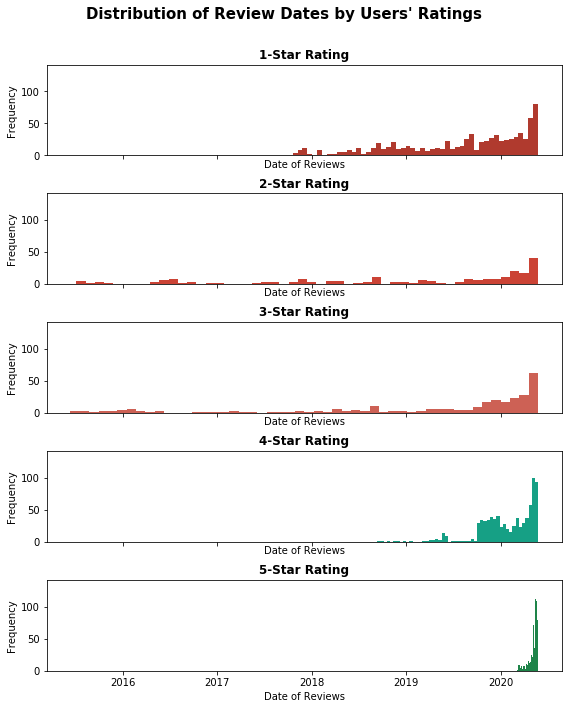

In [52]:
subplot_histograms(main_title="Distribution of Review Dates by Users' Ratings",
                   list_of_titles=['1-Star Rating','2-Star Rating','3-Star Rating','4-Star Rating','5-Star Rating'], 
                   xlabels='Date of Reviews',
                   list_of_colors = ['#B03A2E','#CB4335','#CD6155','#16A085','#1E8449'])

The distributions of review dates differ greatly across various rating scores. While the data collected for 5-star ratings are all dated in the year 2020, some of the 2-star and 3-star reviews are dated back to 2015. In an ideal world, we would like the reviews for each rating score to be collected in equal quantities, over the same time period. However, given that there were not many users that gave a 1-3 score, the data collection for negative reviews had to go back further in time. This was to obtain a balanced class training set, consisting of a relatively equal split between positive and negative reviews.  

A key observation here is that the number of reviews for Shopee on Google Play has increased across all ratings, between Jan and April 2020. This may likely be a result of the recent **rise in e-commerce purchases**. As the COVID-19 outbreak resulted in the forced closure of many brick-and-mortar stores during Singapore's circuit breaker period, many consumers started to turn to online shopping instead.

> According to the Singapore Department of Statistics, e-commerce sales made up 8.5% of total retail takings in March, an increase from 5.8% in January and 7.4% in February.

In [53]:
# 10 reviews written in the context of 'circuit breaker'
len(train[train['content'].str.contains('circuit')])

10

In [54]:
pd.set_option('display.max_colwidth', None)

# Reviews that mentioned the word 'circuit'
train[train['content'].str.contains('circuit')][['content','score']]

,content,score
52,"Fast delivery, easy to order, good and convenient during this circuit breaker period.",5
364,Spent most of the circuit breaker on this online shopping platform. My favorite hobby now.,4
501,Delivery took a bit longer might be due to circuit breaker periods.,5
1067,Very reliable.. Been ordering stuff as im bored at home due to circuit breaker.. Item all receive bfr dateline..,5
1276,Fast delivery even during circuit breaker time.,5
1824,"Shopee very helpfull on circuit breaking period, where almost all the shoping mall are closed. This app easy use, just order, paid & wait your item. Normaly delivery take 2weeks. Hope can be faster. Thanks",5
1848,great experience shopping online during on/off circuit breaker,5
2292,Good experience! Have been shopping more during circuit breaker period. Playing games and collecting some coins to deduct off purchase. Fun! I enjoyed using Shopee a lot. I can find literally everything I want or need from Shopee at cheaper and reasonable price! Thumbs up!,5
3206,It always a good experience using Shoppee my slight problem is the delivery time frame since it's a circuit breaker timeframe it is still acceptable,5
3429,"Great platform during circuit breaker,as we are not able to expose ourself outside to contain the covid19 situations effectively...",5


### Number of thumbs up received

Users can show their approval by giving a "thumbs up" to reviews on Shopee's app. A higher number of thumbs up received from the community will suggest that several others have also been experiencing the same issues.

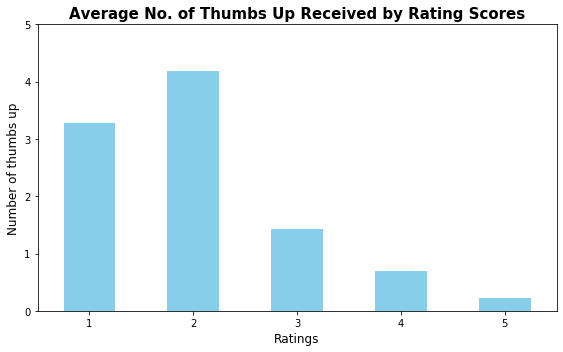

In [55]:
# Group by rating scores and find the average no. of thumbs up per score
train.groupby('score')['thumbs_up_count'].mean().plot(kind='bar', figsize=(8,5), color='skyblue')
plt.xlabel('Ratings', fontsize=12)
plt.xticks(rotation=0)
plt.ylabel('Number of thumbs up', fontsize=12)
plt.ylim(0,5)
plt.title('Average No. of Thumbs Up Received by Rating Scores', fontsize=15, weight='bold')
plt.tight_layout();

Negative reviews with 1 or 2-star ratings receive more thumbs up on average, than positive reviews.

In [56]:
# Show the top 5 reviews that received the highest number of thumbs up
train[['content','thumbs_up_count','score']].sort_values(by='thumbs_up_count', ascending=False).head()

,content,thumbs_up_count,score
1967,"""Warning to all Singapore buyers"" I recently purchased stuffs on shoppee and the seller sent me a faulty product. Within a certain time frame, the seller didnt get back to me on the returning product schedule, shoppee will just release the payment to them and finish the transaction without me getting back the refund. Seriously i feel like being scammed, and dont feel safe at all when shopping on shoppee platform.",199,1
2527,Result is NOT full amt voucher compensation and now chasing me to accept. No apology from dispute team only let support ppl apologize on their behalf. Their dispute team side seller. I buy both English chess board and pieces same time same order only get chess pieces seller only want refund chess board but take my monies for the chess pieces. How I play like that? Hope dispute team demo how to play chess without board. They draw on paper and play on it？Seller shop is runrun2.sg,190,1
1761,"Please avoid using this platform especially if you are doing big purchases. I felt like being scammed by them. They gave huge shopee coins promotion but the validity of the coins are only a mere 2 months. During which, all other purchases to use these earned coins are limited in quantity. They do not allow the usage of all the coins one shot. They are not really an essentials only store where you can spend regularly. So end up the coins will just be forfeited. I lost $60 worth of coins.",148,1
1161,"New update version full of errors. Unable to load my bank account page due to unknown error. Clear cache, log out/in, re-install the apps doesn't help at all. Seek Shopee's troubleshooting team for solution but failed end up they only drag it & revert back as close case. Not a satisfying experience at all. Do not update! You will regret greatly!",115,1
1455,shoppee is a great app to use. the products are affordable although may not be the best quality. I like the shipping details so it gives me an estimated time for items to arrive. It is also easy to compare price for similar products.,113,4


### Number of meaningful words

We will compare the length of the reviews among positive vs negative sentiments.

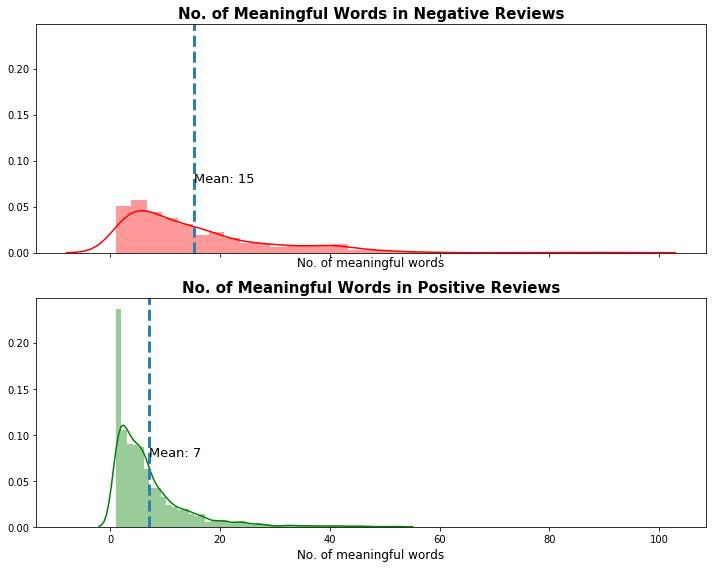

In [57]:
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True, sharey=True)

# Plots the distribution of the length of negative reviews
neg_len = train[train['target']==1]['content_clean_len']
sns.distplot(neg_len, color='red', ax=ax[0])
ax[0].axvline(neg_len.mean(), linestyle='dashed', linewidth=3, c='#2980B9') # Plot the mean line
ax[0].text(x=neg_len.mean(),
           y=0.08,
           s=f'Mean: {round(neg_len.mean())}', 
           horizontalalignment='left', 
           verticalalignment='center',
           fontsize=13)
ax[0].set_title('No. of Meaningful Words in Negative Reviews', fontsize=15, fontweight='bold')
ax[0].set_xlabel('No. of meaningful words', size=12)

# Plots the distribution of the length of positive reviews
pos_len = train[train['target']==0]['content_clean_len']
sns.distplot(pos_len, color='green', ax=ax[1])
ax[1].axvline(pos_len.mean(), linestyle='dashed', linewidth=3, c='#2980B9') # Plot the mean line
ax[1].text(x=pos_len.mean(),
           y=0.08,
           s=f'Mean: {round(pos_len.mean())}', 
           horizontalalignment='left', 
           verticalalignment='center',
           fontsize=13)
ax[1].set_title('No. of Meaningful Words in Positive Reviews', fontsize=15, fontweight='bold')
ax[1].set_xlabel('No. of meaningful words', size=12)
plt.tight_layout();

Both distributions are right-skewed, with only a small proportion of posts that have >40 meaningful words. In fact, only 0.6% of positive reviews and 6% of positive reviews have more than 40 meaningful words. The average number of meaningful words in a negative review (15 words) is higher than that in a positive review (7 words). There is also a noticeable higher variance in the number of meaningful words among negative reviews than positive reviews, suggesting that dissatisfied customers are more likely to write longer reviews.

In [58]:
# Number of reviews that had >40 meaningful words
train[train['content_clean_len']>40]['target'].value_counts().sort_index()

0    14
1    86
Name: target, dtype: int64

In [59]:
train['target'].value_counts()

0    2121
1    1357
Name: target, dtype: int64

In [60]:
# Only 0.6% of positive reviews have > 40 meaningful words
14/2121

0.006600660066006601

In [61]:
# 6% negative reviews have > 40 meaningful words
86/1357

0.06337509211495947

### Wordclouds: Most frequently used words

Word clouds are useful in visualising some of the most frequently occurring words in positive and negative reviews.

In [62]:
# Write a function to plot a wordcloud of the most frequently occurring words

def plot_wordcloud(target, title):
    
    # Clean text that we want to wordcloud. Target will be class 1 (negative reviews) or class 0 (positive reviews)
    text = train[train['target']==target]['content_stem'] 

    wordcloud = WordCloud(width=2000, 
                          height=1000, 
                          background_color='white', 
                          max_words=50, # Maximum no. of words in the wordcloud
                          stopwords=STOPWORDS).generate(' '.join(text)) # Remove stopwords
    
    plt.figure(figsize=(10,8))
    plt.title(title, fontsize=15, weight='bold')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # Removes the axis
    plt.tight_layout()

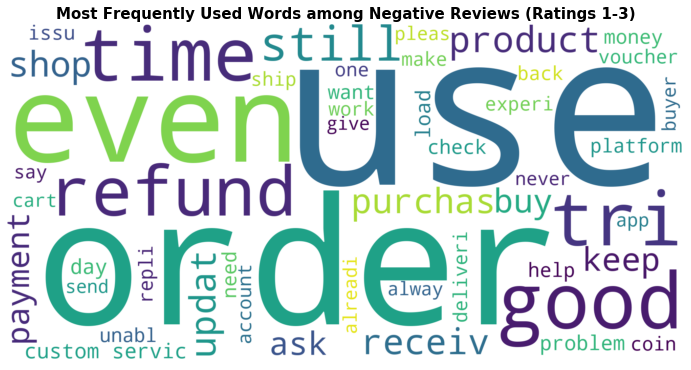

In [63]:
# Wordcloud of the 50 most frequently occurring words among negative reviews
plot_wordcloud(target=1, title='Most Frequently Used Words among Negative Reviews (Ratings 1-3)')

The words 'use' and 'order' are the most frequently seen words among reviews with negative sentiment.

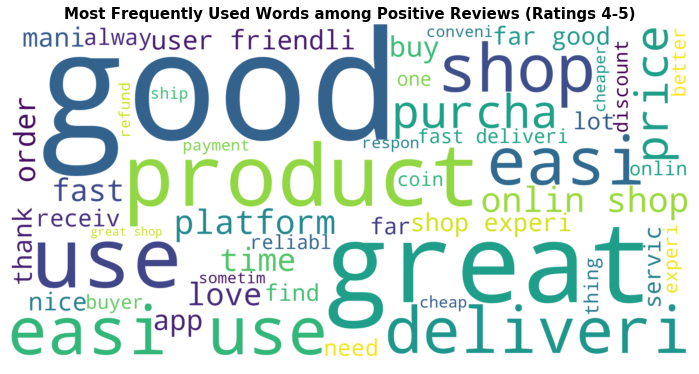

In [64]:
# Wordcloud of the 50 most frequently occurring words among positive reviews
plot_wordcloud(target=0, title='Most Frequently Used Words among Positive Reviews (Ratings 4-5)')

On the other hand, words like 'good', 'great' and 'product' are the top words seen in reviews associated with positive sentiment.

### Barplots: Top uni-grams and bi-grams

We will use CountVectorizer to tokenize our textual data and generate bar plots for the top uni-grams and bi-grams seen in each sentiment. Are there unique words that will help us to distinguish between positive and negative sentiments? Or, are there certain words that are occurring in both sentiments?

In [65]:
# Plots top 20 uni-grams and bi-grams for positive and negative reviews

def barplot_cvec(target, titles, color, xlimit):
    
    words_series = train[train['target']==target]['content_stem']
    
    fig, ax = plt.subplots(1, 2, figsize=(25,12))
    
    ngram = [(1,1),(2,2)] # The ngrams that we would like to plot
    
    for i in range(2):
            
        # Use CountVectorizer to tokenize the text, 
        cvec = CountVectorizer(stop_words='english', ngram_range=ngram[i])

        # Save the tokens in a dataframe
        cvec_df = pd.DataFrame(cvec.fit_transform(words_series).todense(), columns=cvec.get_feature_names())
        sum_words = cvec_df.sum(axis=0) # Sum up the no. of occurences for each word
        top_words = sum_words.sort_values(ascending=False).head(20)
        top_words.sort_values(ascending=True).plot(kind='barh', color=color, ax=ax[i])

        # Adjust plot aesthetics
        ax[i].set_title(titles[i], size=25, weight='bold')
        ax[i].set_xlabel('Count', size=20)
        ax[i].set_xlim(xlimit) # Setting a limit so that the barplots are comparable
        ax[i].tick_params(axis='both', which='major', labelsize=20)
        ax[i].tick_params(axis='both', which='minor', labelsize=20)

    plt.tight_layout()

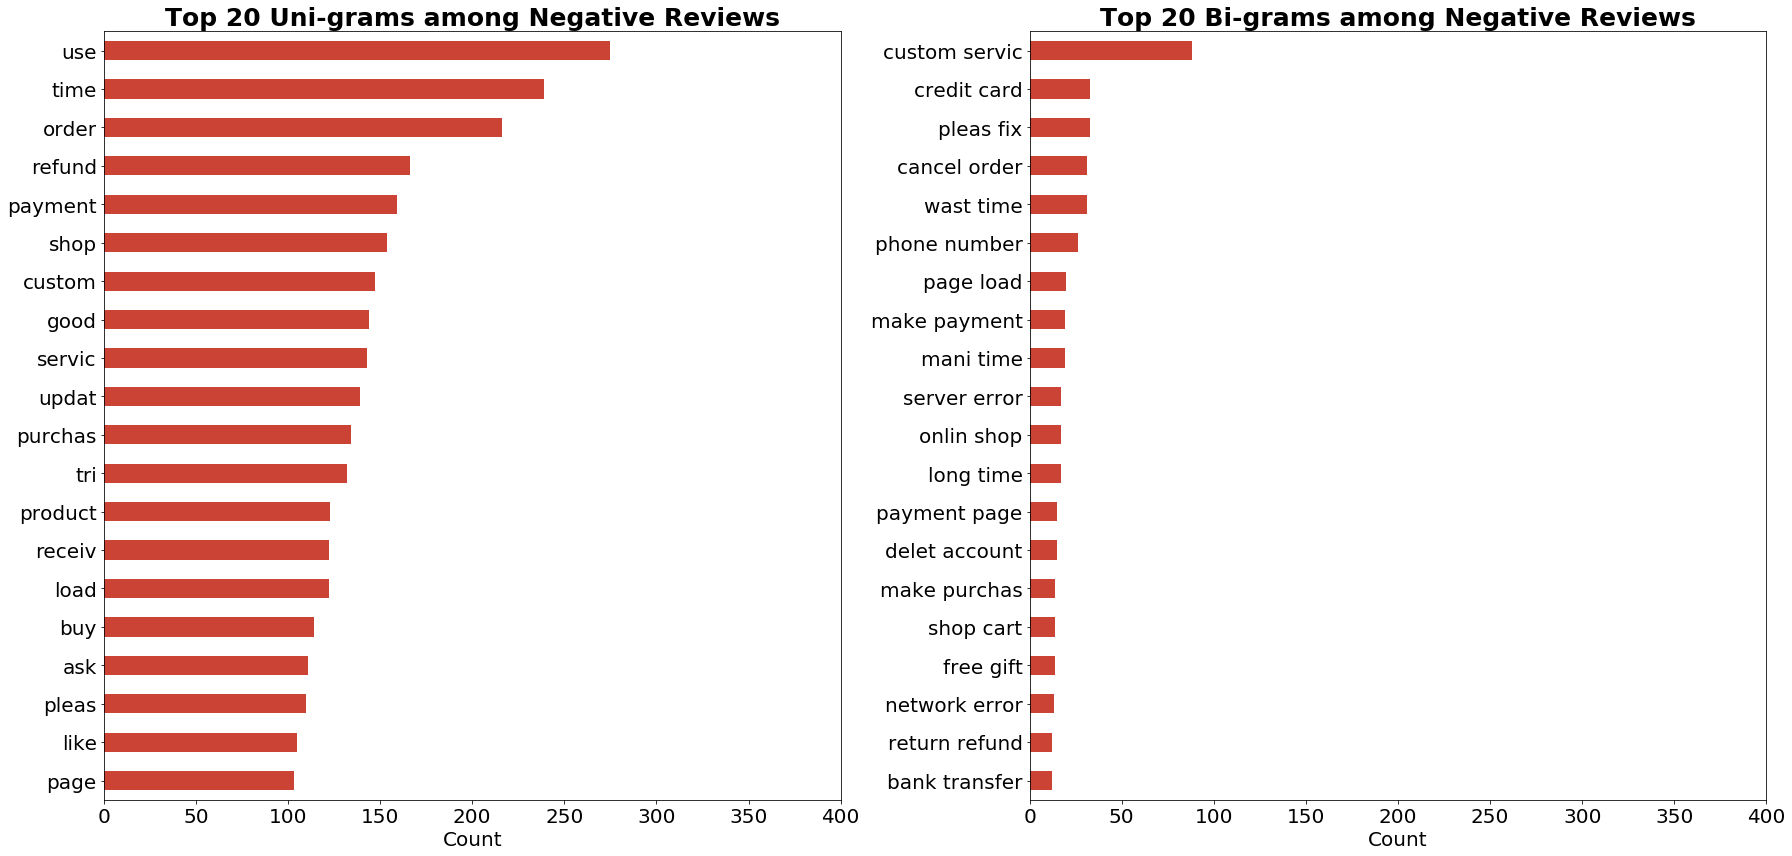

In [66]:
# Plot the uni-grams and bi-grams for negative reviews
barplot_cvec(target=1,
             titles=['Top 20 Uni-grams among Negative Reviews','Top 20 Bi-grams among Negative Reviews'], 
             color='#CB4335',
             xlimit=(0,400))

**'Use', 'time' and 'order'** are the top 3 most frequently occurring uni-grams in negative reviews. **'Customer service'** is the top bi-gram seen among negative reviews. We can thus infer that users are somewhat dissatisfied with Shopee's customer service. 

In [67]:
# Showing some of the negative reviews with the word 'use'
train[(train['target']==1) & (train['content_stem'].str.contains('time'))][['content','score']].head()

,content,score
7,"Terrible payment. For a long time I have been using credit/debit payment without any glitch. Today, I kept being denied of my payment. Error message: Oops payment failed. Did all the steps given by the help desk but still no go. Very annoying to face this issue. On another note, why can't you add more payment methods like PayPal instead of just IBG?",2
21,Been using the app for a long time but it's been very slow these past few weeks . It takes quite a while to load . Please do look into this,3
24,"sadly it filters out other shopee accounts from other country. therefore, in shopee sg are mostly local base resellers. as a result, some of the waiting time would stil be 2-4weeks working days. Also their dispute system is the worse ever. Simply take too long to response.",1
27,"The option for bank transfer should be shortened in time. 3 days is too \nlong, that makes them sometimes forget the unpaid deal, drag too long for \nsellers too. Should be either 1 or 2 days max. The product category is \npretty vague for some products. The product uploaded keep being deleted for \nsome weird and unclear reason.",1
61,"I have a funny expirience i want to buy some tools then i found so nice at the picture so i order it quickly, after two days my order was at home im so excited that time but when i open it it was a toy.😂 seriously a toy? What's this shopee",1


In [68]:
# Showing some of the negative reviews with the word 'time'
train[(train['target']==1) & (train['content_stem'].str.contains('time'))][['content','score']].head()

,content,score
7,"Terrible payment. For a long time I have been using credit/debit payment without any glitch. Today, I kept being denied of my payment. Error message: Oops payment failed. Did all the steps given by the help desk but still no go. Very annoying to face this issue. On another note, why can't you add more payment methods like PayPal instead of just IBG?",2
21,Been using the app for a long time but it's been very slow these past few weeks . It takes quite a while to load . Please do look into this,3
24,"sadly it filters out other shopee accounts from other country. therefore, in shopee sg are mostly local base resellers. as a result, some of the waiting time would stil be 2-4weeks working days. Also their dispute system is the worse ever. Simply take too long to response.",1
27,"The option for bank transfer should be shortened in time. 3 days is too \nlong, that makes them sometimes forget the unpaid deal, drag too long for \nsellers too. Should be either 1 or 2 days max. The product category is \npretty vague for some products. The product uploaded keep being deleted for \nsome weird and unclear reason.",1
61,"I have a funny expirience i want to buy some tools then i found so nice at the picture so i order it quickly, after two days my order was at home im so excited that time but when i open it it was a toy.😂 seriously a toy? What's this shopee",1


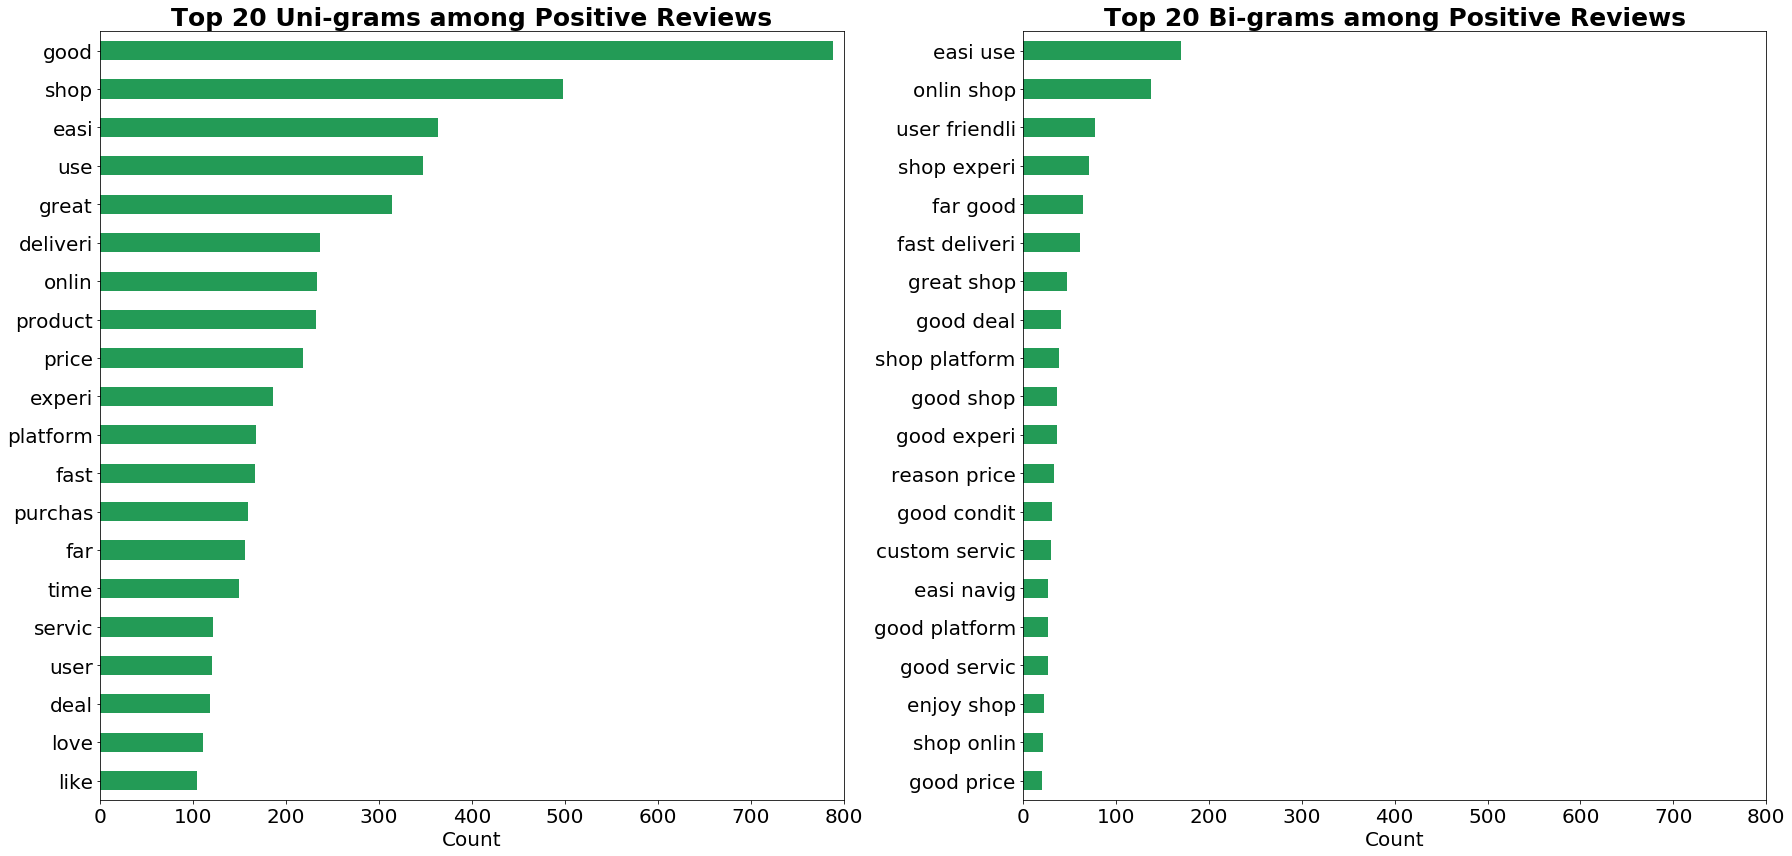

In [69]:
# Plot the uni-grams and bi-grams for positive reviews
barplot_cvec(target=0,
             titles=['Top 20 Uni-grams among Positive Reviews','Top 20 Bi-grams among Positive Reviews'], 
             color='#239B56',
             xlimit=(0,800))

**'Good', 'shop' and 'easi'** are the top 3 most frequently seen uni-grams in positive reviews. The bi-grams give us some context to the word 'easi', where it probably refers to an 'easy to use online shopping platform'.  

In [70]:
# Showing some of the positive reviews with the word 'good'
train[(train['target']==0) & (train['content_stem'].str.contains('good'))][['content','score']].head()

,content,score
3,Overall no complains it's good,5
8,Good,4
9,"So far so good, maybe can increase the reward of games n daily login. I remembered last time is 10 coins on 7th day, now is 7 coins.",4
20,Good price and relatively fast delivery.,5
23,Most seller is respose fast on message send and good quality of the item,5


In [71]:
# Showing some of the positive reviews with the word 'shop'
train[(train['target']==0) & (train['content_stem'].str.contains('shop'))][['content','score']].head()

,content,score
6,"Great place to shop, very competitive pricing and choices. Love the overall experience. 👍",5
12,"Been shopping quite a while with shoppe, nagivation is easy and discount for some products are great. Reliable and refund is done promptly.",5
19,I enjoyed shipping alot at shopee. I have also share my shopping experience with my family members and friends.,5
40,"Although at times met with some unscrupulous sellers, but overall Shopee make my shopping experience wonderful.",4
48,"One of the easiest and best online shop, reliable.",5


### VADER sentiment analysis

[VADER](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf) is a lexicon-based sentiment analysis tool that is specifically attuned to social media sentiments. We will use VADER to generate polarity scores for each review.

In [72]:
# Instantiate the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

In [73]:
# Print a negative review in the training set
print(train.loc[2524,'content'])

# VADER's polarity scores for the negative review
sia.polarity_scores(train.loc[2524,'content'])

Lousy app can't even sign up ask for email address ones key in still asking to log in again and again try to use face book same problem. 🙄😡 uninstal app


{'neg': 0.154, 'neu': 0.846, 'pos': 0.0, 'compound': -0.7351}

The compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1 (extremely negative sentiment) and +1 (extremely positive sentiment). VADER returns a compound score of -0.7351 in the example above, suggesting that it does well in predicting negative sentiment here. This is likely a result of VADER's ability to identify sentiment based on emojis, in addition to words. As VADER works well with emojis, slangs and even punctuations, we will evaluate VADER's performance on raw text, rather than the pre-processed text.

In [74]:
# Create an empty list to append the polarity scores
sia_list = []

# Loop through the text in the training dataset and create a dictionary of the VADER scores
for text in train['content']:
    sia_dict = {}
    sia_dict['neg'] = sia.polarity_scores(text)['neg'] # Negative score
    sia_dict['neu'] = sia.polarity_scores(text)['neu'] # Neutral score
    sia_dict['pos'] = sia.polarity_scores(text)['pos'] # Positive scores
    sia_dict['compound'] = sia.polarity_scores(text)['compound'] # Compound scores
    sia_list.append(sia_dict) # Append the dictionary of scores to the sia_list

In [75]:
# Create a dataframe from the sia_list
sia_df = pd.DataFrame(sia_list)

In [76]:
# Include 'content' and 'target' in sia_df
sia_df['content'] = train['content']
sia_df['target'] = train['target']

In [77]:
# View first 5 rows of sia_df
sia_df.head()

,neg,neu,pos,compound,content,target
0,0.069,0.571,0.360,0.9786,For god sake yr welcome gift T&C isnt stated clearly. I ordered a item so I can get the free welcome gift without feeling bad. After that try selecting a free gift and keep getting a error. Spoke to a CSO and was told I had to get the free gift FIRST before making a purchase!Good job. Not gonna use it again after getting the order.,1
1,0.000,0.834,0.166,0.9537,"Shopee has a wild variety of products however i will only buy certain stuffs . I would prefer stuffs to come with long warranty. Usually for clothings , i prefer brick and motar , see whether it fits . As long as physical products , i would gladly purchase , best can include warranty . I will go only for the quality . This app is very handy . I know where to save money when purchasing . It has some really good stuffs . I will keep coming back , a very good place for bargains .",1
2,0.000,0.573,0.427,0.6682,Cheap and very fast...I love order here..,0
3,0.000,0.371,0.629,0.6229,Overall no complains it's good,0
4,0.000,1.000,0.000,0.0000,Reliable and cheap👍👍👍,0


In [78]:
# Create empty lists to append the accuracy score for each compound score threshold level
threshold = []
accuracy = []

# Loop through a range of compound scores from -1 to +1 and calculate the accuracy score for each compound score
for i in np.linspace(-1, 1, 1000):
    vader_prediction = sia_df['compound'].map(lambda x: 0 if x > i else 1)
    score = accuracy_score(sia_df['target'], vader_prediction)
    threshold.append(i)
    accuracy.append(score)

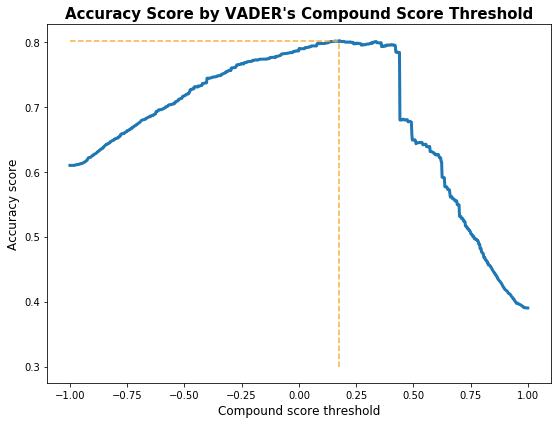

In [79]:
plt.figure(figsize=(8,6))

# Plots the accuracy score against compound score threshold
plt.plot(threshold, accuracy, linewidth=3)

# Plot a horizontal line that represents the best accuracy score achievable
plt.plot([-1,threshold[np.argmax(accuracy)]],[max(accuracy),max(accuracy)], linestyle='dashed', color='#F5B041')

# Plot a vertical line to show the corresponding compound score threshold for the best accuracy score
plt.plot([threshold[np.argmax(accuracy)],threshold[np.argmax(accuracy)]],[0.3,max(accuracy)], linestyle='dashed', color='#F5B041')

plt.title("Accuracy Score by VADER's Compound Score Threshold", size=15, weight='bold')
plt.ylabel('Accuracy score', size=12)
plt.xlabel('Compound score threshold', size=12)
plt.tight_layout()

In [80]:
print("VADER's best accuracy score: ", max(accuracy))
print('Compound score threshold: ', threshold[np.argmax(accuracy)])

VADER's best accuracy score:  0.8018976423231743
Compound score threshold:  0.1751751751751751


The chart above shows the respective accuracy score for every compound score threshold between -1 and 1. Given that we can shift the threshold to achieve the best accuracy score on our training set, if the compound score threshold was set at 0.175, VADER will be able to correctly classify 80% of the sentiments in our training data.

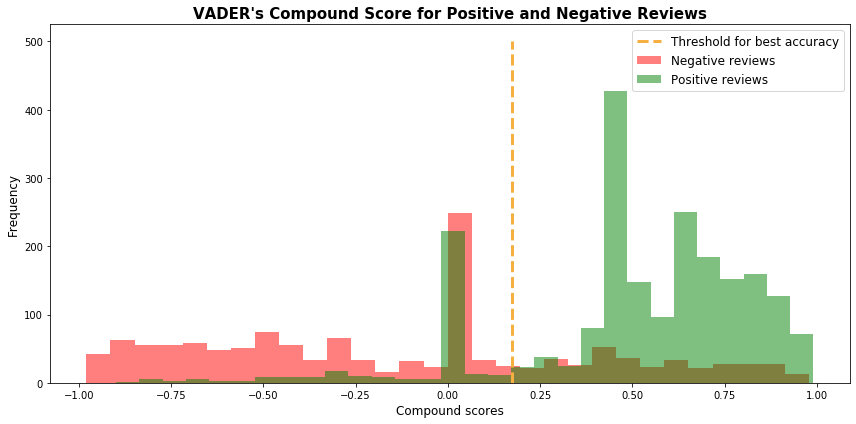

In [81]:
plt.figure(figsize=(12,6))

# Plot a histogram of the compound scores for negative reviews
sia_df[sia_df['target']==1]['compound'].hist(grid=False, color='red', alpha=0.5, bins=30)

# Plot a histogram of the compound scores for positive reviews
sia_df[sia_df['target']==0]['compound'].hist(grid=False, color='green', alpha=0.5, bins=30)

# Plot a vertical line to show the corresponding compound score threshold for the best accuracy score
plt.plot([threshold[np.argmax(accuracy)],threshold[np.argmax(accuracy)]],[0,500], linestyle='dashed', linewidth=3, color='#F5B041')

plt.title("VADER's Compound Score for Positive and Negative Reviews", size=15, weight='bold')
plt.legend(['Threshold for best accuracy','Negative reviews', 'Positive reviews'], fontsize=12)
plt.ylabel('Frequency', size=12)
plt.xlabel('Compound scores', size=12)
plt.tight_layout();

The chart above illustrates the distribution of the VADER compound scores for both the positive and negative reviews. In order to achieve the highest accuracy score of 80% on the training set, the compound score threshold will need to be adjusted to 0.175. However, as seen by the peak around the 0 score mark, this threshold will result in quite a few misclassifications of positive reviews. These positive reviews are likely to consist of rather neutral sentiment, thus leading to borderline scores of around 0.

In [82]:
# Prediction with compound threshold of 0.175
sia_df['vader_prediction'] = sia_df['compound'].map(lambda x: 0 if x > threshold[np.argmax(accuracy)] else 1)

In [83]:
# VADER's best accuracy score
accuracy_score(sia_df['target'], sia_df['vader_prediction'])

0.8018976423231743

In [84]:
# Confusion matrix
cm = confusion_matrix(sia_df['target'], sia_df['vader_prediction'])
cm_df = pd.DataFrame(cm, columns=['Predicted Positive Review','Predicted Negative Review'], index=['Actual Positive Review', 'Actual Negative Review'])
cm_df

,Predicted Positive Review,Predicted Negative Review
Actual Positive Review,1783,338
Actual Negative Review,351,1006


In [85]:
# Classification report
print(classification_report(sia_df['target'], sia_df['vader_prediction']))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2121
           1       0.75      0.74      0.74      1357

    accuracy                           0.80      3478
   macro avg       0.79      0.79      0.79      3478
weighted avg       0.80      0.80      0.80      3478



Given a compound score threshold of 0.175, VADER is able to correctly classify 80% of sentiments. As Shopee's product managers would also like to prioritise the identification of negative reviews so that they can fix immediate problems if necessary, achieving a decent recall rate is important. VADER is able to correctly classify 74% of actual negative reviews. It will be interesting to see if our machine learning models will be able to outperform VADER on accuracy and recall.

In [86]:
# Negative reviews that were predicted to be positive reviews
sia_df[(sia_df['target']==1) & (sia_df['vader_prediction']==0)].head(10)

,neg,neu,pos,compound,content,target,vader_prediction
0,0.069,0.571,0.360,0.9786,For god sake yr welcome gift T&C isnt stated clearly. I ordered a item so I can get the free welcome gift without feeling bad. After that try selecting a free gift and keep getting a error. Spoke to a CSO and was told I had to get the free gift FIRST before making a purchase!Good job. Not gonna use it again after getting the order.,1,0
1,0.000,0.834,0.166,0.9537,"Shopee has a wild variety of products however i will only buy certain stuffs . I would prefer stuffs to come with long warranty. Usually for clothings , i prefer brick and motar , see whether it fits . As long as physical products , i would gladly purchase , best can include warranty . I will go only for the quality . This app is very handy . I know where to save money when purchasing . It has some really good stuffs . I will keep coming back , a very good place for bargains .",1,0
15,0.000,0.815,0.185,0.5574,"hi im from Philippines, y is it that my number is always invalid? it says here that i need to enter a number that is valid in singapore and malaysia.. pls help me",1,0
16,0.000,0.000,1.000,0.4404,Good,1,0
21,0.000,0.910,0.090,0.4497,Been using the app for a long time but it's been very slow these past few weeks . It takes quite a while to load . Please do look into this,1,0
42,0.000,0.899,0.101,0.2023,Recent update of the app facing Internet connectivity issues specific to the app. Other apps load fine.,1,0
47,0.000,0.312,0.688,0.2960,Still ok,1,0
51,0.000,0.777,0.223,0.3182,Cannot proceed with the payment using visa. Please check.,1,0
55,0.049,0.833,0.117,0.9034,"I don't know what the heck is happening but all my items that are being bought have been stuck at like the sorting hubs or like cross border transit , then shoppee ask me to extend guarantee for those items ( which is 90% of my "" to recieve "" ) , then ofc if they in another country the guarantee expect the items to come to singapore in like 2 or 3 days , so fast ? i dont even know how to grasp the concept of that , then after waiting so long for an item that i bought 1 month over now need to be refunded ? seriously whats happening ??? this phenomena happend to like 90% of my items that ive yet to recieved . At this pace all my item that ive bought will have to be refunded. Then whats the point of shopping on it ? in the end all also wasted ?",1,0
58,0.000,0.824,0.176,0.5927,3.75 stars.Safe shopping but can't find any Chinese herbs to shop. Hope there will be Chinese herbs to buy.,1,0


In [87]:
# Positive reviews that were predicted to be negative reviews
sia_df[(sia_df['target']==0) & (sia_df['vader_prediction']==1)].head(10)

,neg,neu,pos,compound,content,target,vader_prediction
4,0.000,1.000,0.000,0.0000,Reliable and cheap👍👍👍,0,1
29,0.000,1.000,0.000,0.0000,Everything oj,0,1
34,0.000,1.000,0.000,0.0000,Can you fix the issue!!! Its down the drain since the last update!!!,0,1
75,0.000,1.000,0.000,0.0000,App sometimes gets laggy,0,1
82,0.000,1.000,0.000,0.0000,90% is very fast in shipping,0,1
85,0.129,0.723,0.148,-0.1048,I love shopee app and I can enjoy the deal for online shopee but the $1.00 I buy so many time but never get to win.,0,1
91,0.000,1.000,0.000,0.0000,Gd app to shop in,0,1
98,0.055,0.868,0.077,0.0923,"a very good app to use and parcel not delayed despite the virus outbreak. The only bad thing is that I do not have the choice to choose the delivery time, for the parcel to be delivered to my house and have to reschedule with ninja van again if I am not at home to collect the parcel.",0,1
104,0.078,0.922,0.000,-0.1761,Can you add more payment options bacause as a kid it's very hard to find apps that have cash on delivery,0,1
119,0.129,0.871,0.000,-0.5129,Vouchers given are difficult to get. Getting the vouchers doesn't mean you're entitled to the savings / discounts. Must make quick purchasing decisions. Takes time to get familiar with the system.,0,1


## Save clean datasets for modeling

In [88]:
# Keep only the columns that we need for modeling and interpretation
train = train[['content','content_stem','score','target']]
test = test[['content','content_stem','score','target']]

In [89]:
# Save clean training set
train.to_csv('../data/clean_train.csv', index=False)

In [90]:
# Save clean test set
test.to_csv('../data/clean_test.csv', index=False)